---
# **Visualize KITTI Road Dataset**
---

**Imports**

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

**Directories**

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_data_dir = "/DML/Datasets/KITTI_ROAD/training/image_2/"
train_gt_dir = "/DML/Datasets/KITTI_ROAD/training/gt_image_2/"
test_data_dir = "/DML/Datasets/KITTI_ROAD/testing/"

**Initialize Parameters**

In [3]:
IMG_SIZE = 512
BATCH_SIZE = 16
torch.manual_seed(42)   # Set random seed for reproducibility

**Dataset Class (including Pre-processing)**

In [4]:
class KittiRoadDataset(Dataset):
    def __init__(self, sample_images_dir, sample_masks_dir, img_format="*.png", mask_format="*.png", transform=None, label_filter="road"):
        # Load and sort images and masks
        self.img_files = sorted(list(Path(sample_images_dir).glob(img_format)))
        self.mask_files = sorted(list(Path(sample_masks_dir).glob(mask_format)))

        # Filter masks for the class "label_filter"
        if label_filter:
            self.mask_files = [file for file in self.mask_files if label_filter in os.path.basename(file)]
        
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("RGB")  # Color mask

        # Resize image and mask before converting the mask to binary
        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask = mask.resize((IMG_SIZE, IMG_SIZE))

        # Convert the mask to a binary class label (1=road, 0=not road)
        mask = self.binary_encode_mask(np.array(mask))

        # Apply transformations to image and mask
        if self.transform:
            image = self.transform(image)
            # mask = self.transform(mask)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to a 1xHxW tensor

        return image, mask

    def binary_encode_mask(self, mask_array):
        # Define the color labels (KITTI road: magenta, non-road: red, background: black)
        road_label = np.array([255, 0, 255])  # Magenta for road
        non_road_label = np.array([255, 0, 0])  # Red for non-road

        # Create binary mask: 1 for road, 0 for non-road
        binary_mask = np.all(mask_array == road_label, axis=-1).astype(np.uint8)

        return binary_mask
    

**Loading the Data**

In [5]:
# Define image transformations
# transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = KittiRoadDataset(train_data_dir, train_gt_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Visualization**

Image Shape: torch.Size([16, 3, 512, 512])
Mask Shape: torch.Size([16, 1, 512, 512])


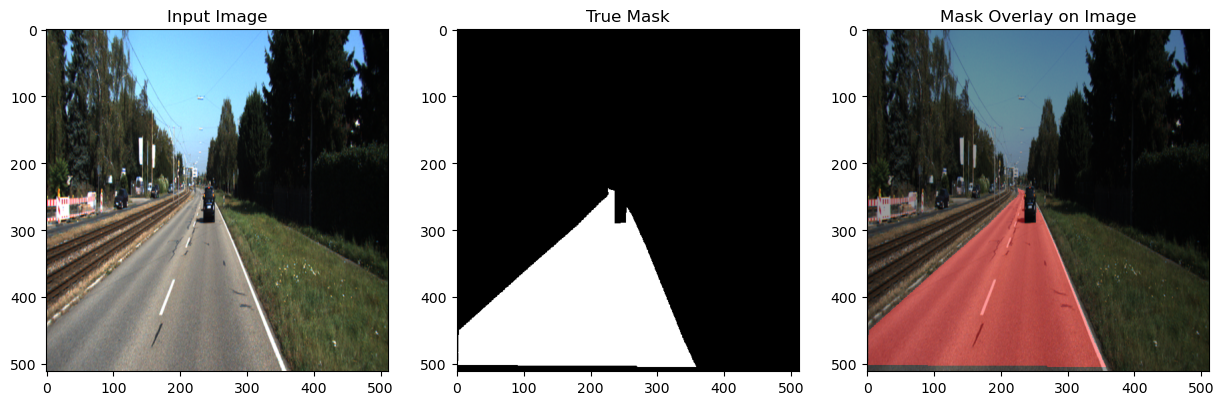

In [8]:
# Fix for OpenMP conflict
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.set_num_threads(1)

# Function to overlay mask on the input image
def overlay_mask_on_image(image, mask, alpha=0.4):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Ensure mask is 2D for overlay
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Normalize image (if needed) to be in the range [0, 1]
    image = image.permute(1, 2, 0)   # [C, H, W] -> [H, W, C]
    image = (image - image.min()) / (image.max() - image.min())

    # Convert the mask to RGB for overlaying
    mask_rgb = torch.stack([mask, torch.zeros_like(mask), torch.zeros_like(mask)], dim=-1)

    # Overlay: blend the mask and image using alpha
    overlay = (1 - alpha) * image + alpha * mask_rgb

    return overlay

# Sample visualization function
def display_sample(image, mask):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = mask.cpu().detach()

    # Squeeze the mask if it has an extra dimension
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Create figure with three subplots: image, mask, overlay
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    # Plot the input image
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title('Input Image')

    # Plot the mask (ensure it's 2D for grayscale)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('True Mask')

    # Create and plot the overlay image
    overlay = overlay_mask_on_image(image, mask)
    ax[2].imshow(overlay)
    ax[2].set_title('Mask Overlay on Image')

    plt.show()

# Display a sample from the dataset
for images, masks in train_loader:
    print(f"Image Shape: {images.shape}") 
    print(f"Mask Shape: {masks.shape}")
    display_sample(images[0], masks[0])
    break